In [1]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [2]:
es = Elasticsearch()

In [3]:
# open a file, where you stored the pickled data
file = open('dataset.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [4]:
len(data["p"])

5000

In [5]:
len(data["n"])

5000

In [6]:
p_dois=[]
n_dois=[]
openalex = []
scopus = []
for i in data["p"]:
    p_dois.append(i[0]["DOI"])
    openalex.append(i[1])
    scopus.append(i[0])
for i in data["n"]:
    n_dois.append(i[0]["DOI"])
    openalex.append(i[1])
    scopus.append(i[0])

In [7]:
es_index = "openalex"
recreate = True
if recreate:
    if es.indices.exists(index=es_index):
        es.indices.delete(index=es_index)
if not es.indices.exists(index=es_index):
    es.indices.create(index=es_index)

In [8]:
if recreate:
    request_timeout = 60
    bulk_size = 100

    es_entries = []
    counter = 0
    for i in openalex:
        entry = {"_index": es_index,
                 "_id": counter,
                 "_source": i}
        es_entries.append(entry)
        if len(es_entries) == bulk_size:
            helpers.bulk(es, es_entries, refresh=True,request_timeout=request_timeout)
            es_entries = []
        counter +=1

In [9]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['doi']


In [10]:
openalex[0]

{'doi': 'https://doi.org/10.1001/archderm.134.2.143',
 'title': 'Ivermectin for Crusted Norwegian Scabies Induced by Use of Topical Steroids',
 'publication_year': 1998,
 'host_venue': {'display_name': 'Archives of Dermatology'},
 'authorships': [{'author': {'display_name': 'Felipe Jaramillo-Ayerbe'}},
  {'author': {'display_name': 'Joaquín Berrío-Muñoz'}}]}

In [11]:
def search(Title, Authors, Source, Year, punto_de_corte = 80.0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    body = {
        "query": {
            "bool": {
                "should": [
                    { "match": { "title":  Title }},
                    { "match": { "authorships.author.display_name": Authors }},
                    { "match": { "host_venue.display_name":  Source}},
                    { "match": { "publication_year": Year }}
                ]
            }
        },
        "size": 10
    }
    
    res = es.search(index=es_index, **body)
    hits = []
    
    for i in res["hits"]["hits"]:
        if i["_score"] >= punto_de_corte:
            hits.append(i)
    res["hits"]["hits"] = hits
    return  res


In [12]:
%%time

def es_similarity(rec,p,th):
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],th)
    if p:
        if len(res["hits"]["hits"]) > 1:
            oa_doi = get_oa_doi(res["hits"]["hits"][0]).replace("https://doi.org/","")
            sc_doi = rec["DOI"]
            if oa_doi == sc_doi and oa_doi in p_dois:
                return True
        return False
    else:
        #sc_doi = rec["DOI"]
        if len(res["hits"]["hits"]) == 0:
            True
        return False

th=0
halt = len(data["p"])
total = len(scopus)
results_p = Parallel(n_jobs=15,backend='threading',verbose=0)(delayed(es_similarity)(rec,True,th) for rec in scopus[0:halt])
results_n = Parallel(n_jobs=15,backend='threading',verbose=0)(delayed(es_similarity)(rec,False,th) for rec in scopus[halt:total])


CPU times: user 5.06 s, sys: 1.04 s, total: 6.1 s
Wall time: 5.2 s


In [13]:
#>tp, tn, fp, fn
actual  = np.concatenate((np.ones(halt, dtype=bool), np.zeros(halt, dtype=bool)))
predicted = np.concatenate((results_p,results_n))

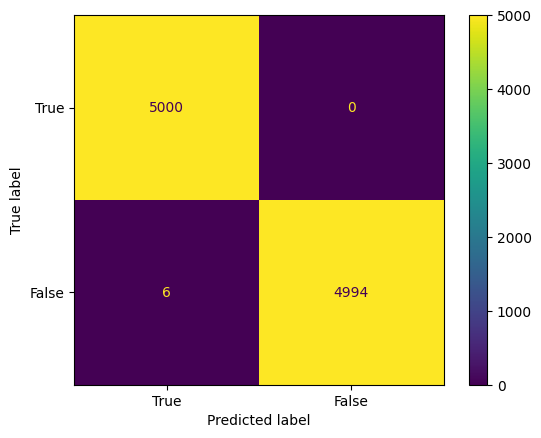

In [14]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()

In [15]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)
f1  = metrics.f1_score(actual,predicted)

print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {pre:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")


Accuracy  = 0.9994
Precision = 1.0000
Recall    = 0.9988
F1        = 0.9994


In [16]:
rec = scopus[0]
print(rec["Title"])
print(rec["DOI"])
res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],0)
res

Ivermectin for crusted Norwegian scabies induced by use of topical steroids
10.1001/archderm.134.2.143


{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 7917, 'relation': 'eq'},
  'max_score': 112.95028,
  'hits': [{'_index': 'openalex',
    '_id': '0',
    '_score': 112.95028,
    '_source': {'doi': 'https://doi.org/10.1001/archderm.134.2.143',
     'title': 'Ivermectin for Crusted Norwegian Scabies Induced by Use of Topical Steroids',
     'publication_year': 1998,
     'host_venue': {'display_name': 'Archives of Dermatology'},
     'authorships': [{'author': {'display_name': 'Felipe Jaramillo-Ayerbe'}},
      {'author': {'display_name': 'Joaquín Berrío-Muñoz'}}]}},
   {'_index': 'openalex',
    '_id': '1',
    '_score': 112.95028,
    '_source': {'doi': 'https://doi.org/10.1001/archderm.134.2.143',
     'title': 'Ivermectin for Crusted Norwegian Scabies Induced by Use of Topical Steroids',
     'publication_year': 1998,
     'host_venue': {'display_name': 'Archives of Dermatology'},
     'authorships': 

In [17]:
search_doi(rec["DOI"])


NameError: name 'search_doi' is not defined

In [ ]:
if "10.1001/archderm.134.2.143" in n_dois:
    print("fond")

In [ ]:
res

In [ ]:
print(rec["Title"])
#print(rec["Title"])

oa_doi = get_oa_doi(res["hits"]["hits"][0])
sc_doi = rec["DOI"]
print(oa_doi,sc_doi)
fuzz.token_sort_ratio(oa_doi,sc_doi)


In [ ]:
rec = scopus[0]
print(rec["DOI"])
search_doi(rec["DOI"])

In [ ]:
%%time
count = 0
for rec in scopus[0:1000]:
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'])
    count +=1
    if count%1000 == 0:
        print(count)